# D213 Performance Assessment Task 1
## Darian Gurrola
## Course Instructor: Dr. Festus Elleh

## A1. 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The question being investigated in this analysis is "Can we predict how much revenue the telecommunications company will earn by using historical data?".  This question will be answered using time series analysis.

## A2. 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The primary objective of this analysis is to forecast the telecommunication company's daily revenue.  To achieve this goal, I will create a time series model using two years of historical data.

## B.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The main assumption of time series models is that the data used is stationary.  This means that the mean, variance, and autocorrelation structure of the data should remain consistent over time (National Institute of Standards and Technology).  A violation of this key assumption could result in an unreliable model and misleading results.  We may need to coerce stationarity and transform the original data if necessary.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Autocorrelation can be defined as a the degree of similarity between two observations at different points in a time series.  Its presence demonstrates that past values in the time series influence future values (Frost).  This is a key aspect of time series modeling.  Later on, we will analyze autocorrelation and partial autocorrelation to determine the best parameters for our model.  

## C1.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Please see the line graph of the time series realization at the end of this section.  The x-axis represents the time series interval (Day), while the y-axis represents the company's revenue in millions of dollars.  The blue line represents the company's daily revenue over time.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import pmdarima as pm
from datetime import datetime
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
df_telecom = pd.read_csv("teleco_time_series.csv")

In [3]:
df_telecom.shape

(731, 2)

In [4]:
df_telecom.head()

,Day,Revenue
0,1,0.000000
1,2,0.000793
2,3,0.825542
3,4,0.320332
4,5,1.082554


In [5]:
df_telecom.describe()

,Day,Revenue
count,731.000000,731.000000
mean,366.000000,9.822901
std,211.165812,3.852645
min,1.000000,0.000000
25%,183.500000,6.872836
50%,366.000000,10.785571
75%,548.500000,12.566911
max,731.000000,18.154769


In [6]:
#Look for null or missing values
df_telecom.isnull().any()

Day        False
Revenue    False
dtype: bool

In [7]:
#Drop any null columns
df_telecom.dropna()

,Day,Revenue
0,1,0.000000
1,2,0.000793
2,3,0.825542
3,4,0.320332
4,5,1.082554
...,...,...
726,727,16.931559
727,728,17.490666
728,729,16.803638
729,730,16.194813


In [8]:
df_telecom.isnull().values.any()

False

In [9]:
#Check for missing values
df_telecom.isna().sum()

Day        0
Revenue    0
dtype: int64

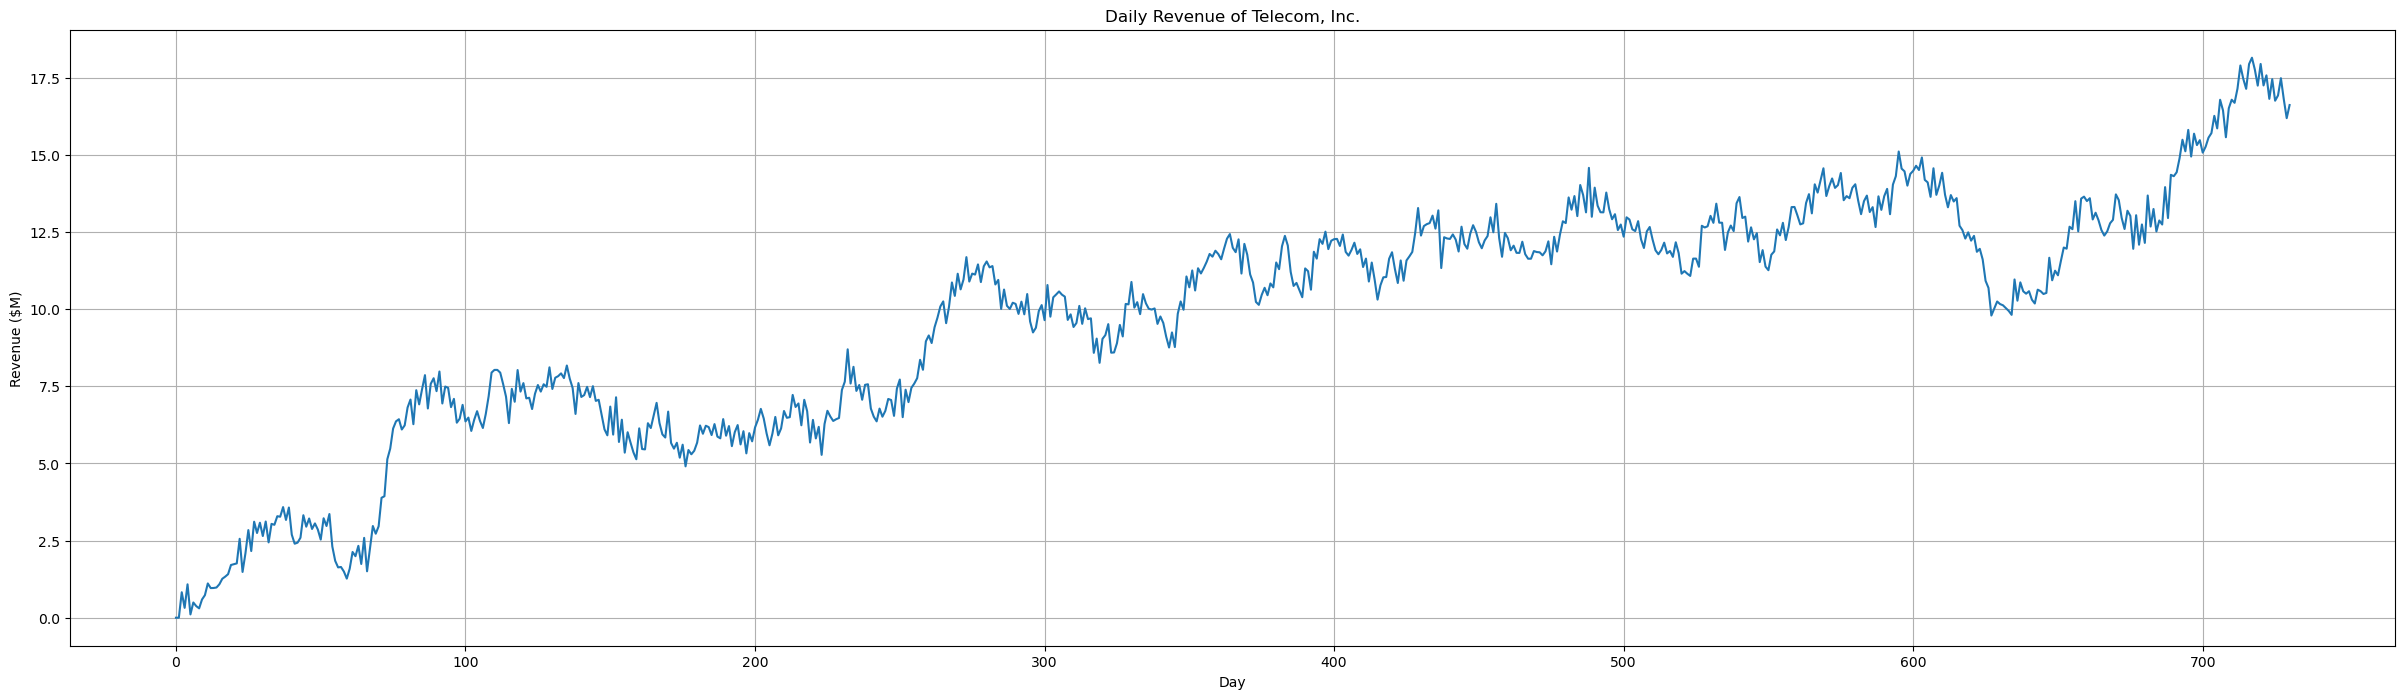

In [10]:
#Generate line graph of time series data
plt.figure(figsize=(30, 8))
plt.plot(df_telecom["Revenue"])
plt.title("Daily Revenue of Telecom, Inc.")
plt.xlabel("Day")
plt.ylabel("Revenue ($M)")
plt.grid(True)
plt.show()

## C2.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;In the previous section I imported the provided csv file to a dataframe called "df_telecom".  I then explored the data to determine if there were any gaps in the time series.  Using the "isnull()" and "isna()" functions, I concluded that there were no missing values.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;To ensure the time step of the realization was formatted properly, I took a few additional steps.  I used the "date_range()" and "datetime()" functions to create a "Date" column.  This column contains a list of dates ranging the length of the time series and beginning on January 1, 2022.  I then set the "Date" column as an index for "df_telecom" using the "set_index()" function.  The final step was to drop the "Day" column, which was no longer needed. 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;I decided to generate another visualization of the time series to see what it would look like when formatted properly.  I observed a repeating seasonal pattern every 90 days, which I would take into account when building my model later on.

In [11]:
#Create Date column which starts on January 1, 2019
df_telecom["Date"] = (pd.date_range(start = datetime(2022, 1, 1), periods = df_telecom.shape[0], freq = 'D'))

#Set Date column as index
df_telecom.set_index("Date", inplace = True)

#Drop Day column from dataframe
df_telecom.drop("Day", axis = 1, inplace = True)

df_telecom

,Revenue
Date,
2022-01-01,0.000000
2022-01-02,0.000793
2022-01-03,0.825542
2022-01-04,0.320332
2022-01-05,1.082554
...,...
2023-12-28,16.931559
2023-12-29,17.490666
2023-12-30,16.803638


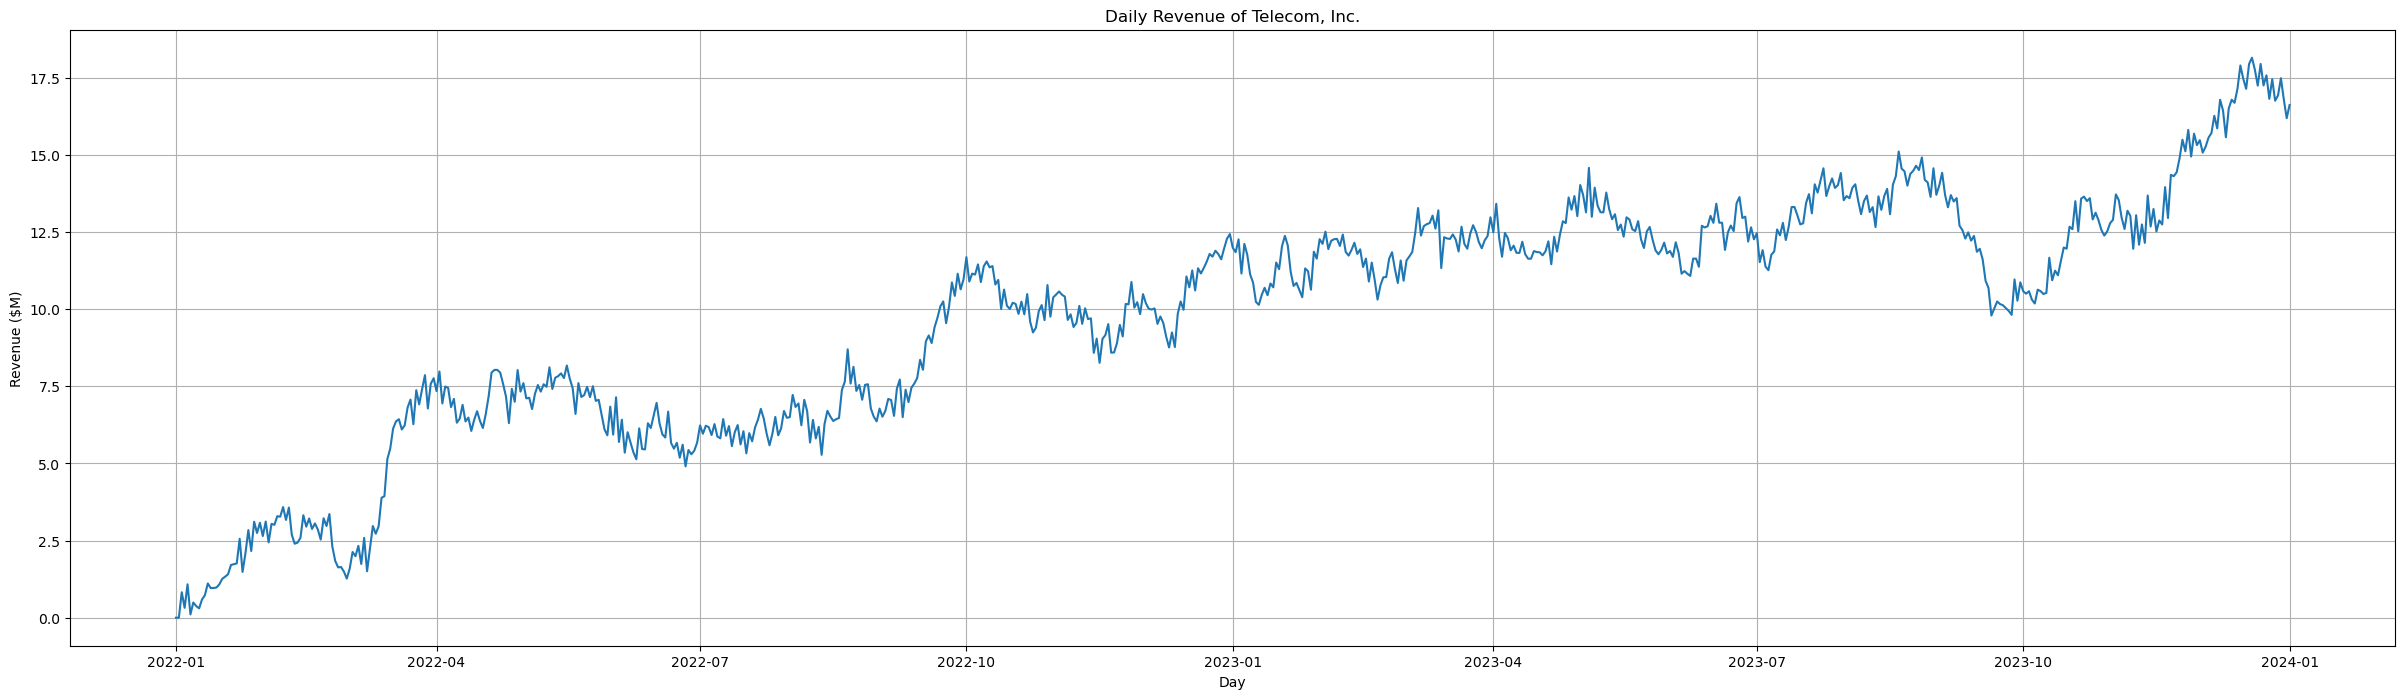

In [12]:
#Generate line graph of time series data
plt.figure(figsize=(30, 8))
plt.plot(df_telecom["Revenue"])
plt.title("Daily Revenue of Telecom, Inc.")
plt.xlabel("Day")
plt.ylabel("Revenue ($M)")
plt.grid(True)
plt.show()

## C3.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;To evaluate the stationarity of the data, we will use an Augmented Dickey-Fuller test.  This test produces a test statistic, a p-value, and critical values at varying significance levels. The null hypothesis of the ADF test is that the data has a unit root, meaning that it is not stationary (Kumar G, 2024).  The alternative hypothesis is that the data does not have a unit root, indicating that it is stationary.  We will interpret the results of the test and determine whether or not we should reject the null hypothesis.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;To perform the test, I used the "adfuller()" method from the statsmodels library and passed the "Revenue" column of df_telecom as a parameter.  The results were assigned to a variable called "results".  To obtain the relevant metrics, I printed out the value of "results" at various indexes.  From the output below we can we see a test statistic of -1.92, a p-value of 0.32, and critical values at varying significance levels.  

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;When performing the ADF test, we can reject the null hypothesis if the test statistic is less than the chosen critical value and if the p-value is less than the chosen significance level (Kumar G, 2024).  From the output below, we can see the the test statistic of -1.92 is greater than the critical value at each significance level.  Additionally, the p-value of 0.32 is greater than my chosen significance level of 0.05.  Based on these results, we cannot reject the null hypothesis.  This indicates that there is likely a unit root in the data, meaning that the time series is not stationary.  

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The next step I took was to difference the data in order to coerce stationarity.  To do this I used the "diff()" function on "df_telecom".  The output was assigned to a new dataframe called "df_diff". After differencing the data, we can see that the values now appear to center around 0.  A second ADF test confirms that the test statistic is now lower than each of the critical values, and the p-value is now less than 0.05.  We can conclude that the data in "df_diff" is now stationary.

In [13]:
#Perform Augmented Dickey-Fuller Test: In-text citation [Statistical Tests to Check Stationarity in Time Series]
results = adfuller(df_telecom["Revenue"])
print("Test Statistics: " + str(results[0]))
print("p-value: " + str(results[1]))
print("Critical values: " + str(results[4]))

Test Statistics: -1.9246121573101873
p-value: 0.32057281507939484
Critical values: {'1%': -3.4393520240470554, '5%': -2.8655128165959236, '10%': -2.5688855736949163}


In [14]:
#Difference the original data to coerce stationarity
df_diff = df_telecom.diff().dropna()

In [15]:
df_diff.head()

,Revenue
Date,
2022-01-02,0.000793
2022-01-03,0.824749
2022-01-04,-0.505210
2022-01-05,0.762222
2022-01-06,-0.974900


In [16]:
#Repeat Augmented Dickey-Fuller Test
results = adfuller(df_diff["Revenue"])
print("Test Statistics: " + str(results[0]))
print("p-value: " + str(results[1]))
print("Critical values: " + str(results[4]))

Test Statistics: -44.874527193875984
p-value: 0.0
Critical values: {'1%': -3.4393520240470554, '5%': -2.8655128165959236, '10%': -2.5688855736949163}


## C4.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;To summarize my previous steps, I imported the initial csv file, explored the data for quality issues, formatted the time step of the realization, checked for stationarity, and differenced the data.  The last step was to split the original data into training and testing subsets.  To do this, I selected the first 641 observations and assigned them to a dataframe called "X_train".  The remaining 90 observations were assigned to "X_test".

In [17]:
#X_train, X_test = train_test_split(df_telecom, test_size=0.2, train_size=0.8, shuffle=False)
X_train = df_telecom.loc[:'2023-10-03']
X_test = df_telecom.loc['2023-10-04':]

print(X_train.shape)
print(X_test.shape)

(641, 1)
(90, 1)


## C5.

A copy of the cleaned testing and training datasets have been submitted with this assignment.  The files are named "X_train.csv" and "X_test.csv".  

In [18]:
X_train.to_csv("X_train.csv")
X_test.to_csv("X_test.csv")

## D1.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;To compare the original and stationary datasets, I generated a few different visualizations.  I began by decomposing both sets of data using the "seasonal_decompose()" function from the statsmodels library.  This method splits the time series into trend, seasonal, and residual components (Mahler, 2023).  In a moment, we will discuss each of these components in greater detail.

## Decomposed Time Series

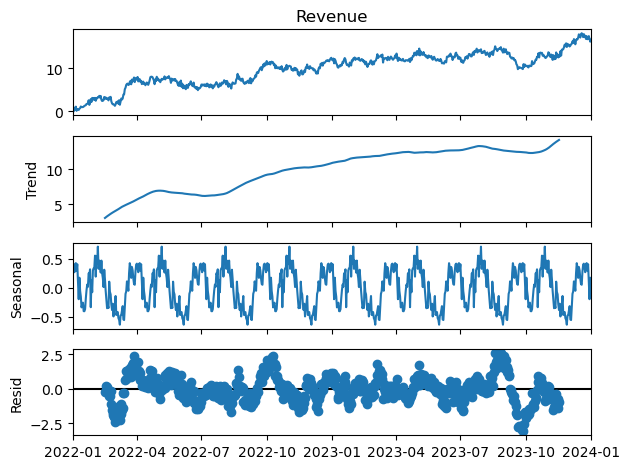

In [19]:
#Perform seasonal decomposition of non-stationary time series.  Use 90 day period based on updated line graph. 
decomp = seasonal_decompose(df_telecom["Revenue"], period = 90)
decomp.plot()
plt.show()

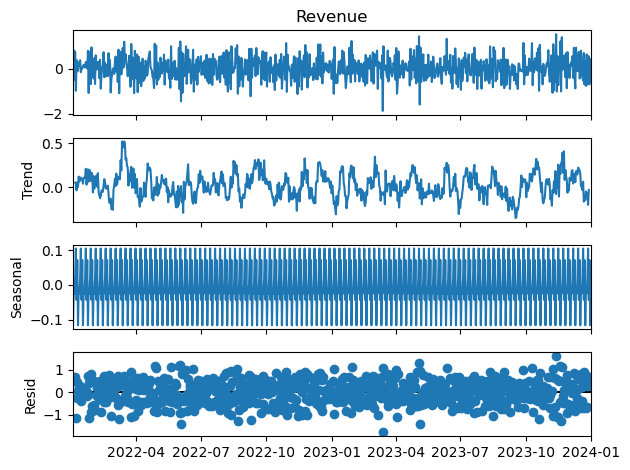

In [20]:
#Perform seasonal decomposition of stationary time series 
decomp_diff = seasonal_decompose(df_diff["Revenue"])
decomp_diff.plot()
plt.show()

## Seasonal Component

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The graphs below represent the seasonal component of the original and stationary data.  We can summarize seasonality as a repeating pattern that takes place within a specific time interval (Mahler, 2023).  In this case, I used a seasonal interval of 90 days based on the pattern I identified earlier.  When looking at the original data, we can see a distinct repeating pattern with a the seasonality ranging between values of -0.6 and 0.6.  In comparison, the stationary data has insignificant seasonality with values ranging between -0.1 and 0.1.  

<Axes: title={'center': 'Seasonality (Original)'}, xlabel='Date'>

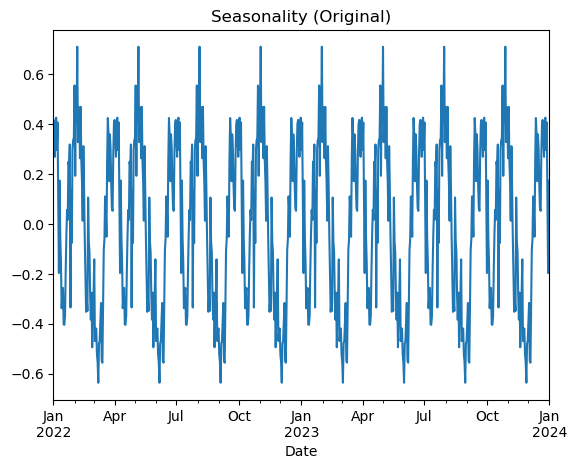

In [21]:
## Plot seasonality from the non-stationary data
plt.title('Seasonality (Original)')
decomp.seasonal.plot()

<Axes: title={'center': 'Seasonality (Stationary)'}, xlabel='Date'>

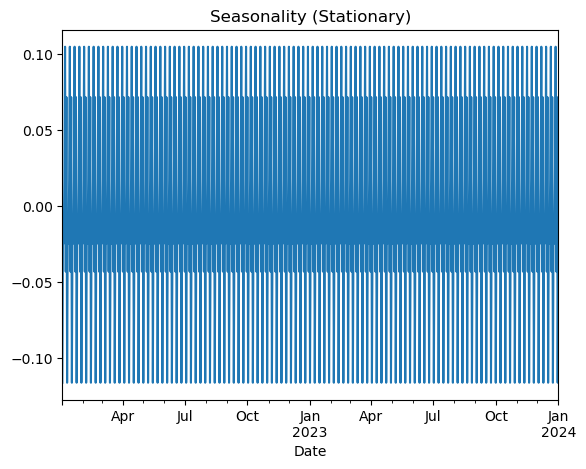

In [22]:
## Plot seasonality from the stationary data
plt.title('Seasonality (Stationary)')
decomp_diff.seasonal.plot()

## Trend Component

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Next, we'll compare the trend component of the original and stationary data.  Trend can be summarized as a long-term upward or downward movement in the data (Mahler, 2023).  It indicates if there is a general increase or decrease in the values over time.  When reviewing the trend component of the original data, we can see a clear positive trend indicating a general increase in revenue over time.  In contrast, the stationary data lacks a clear trend as values fluctuate around 0.

<Axes: title={'center': 'Trend (Original)'}, xlabel='Date'>

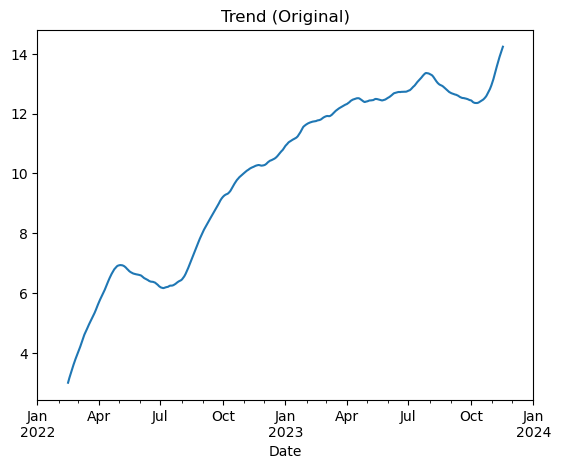

In [23]:
## Plot seasonality from the non-stationary data
plt.title('Trend (Original)')
decomp.trend.plot()

<Axes: title={'center': 'Trend (Stationary)'}, xlabel='Date'>

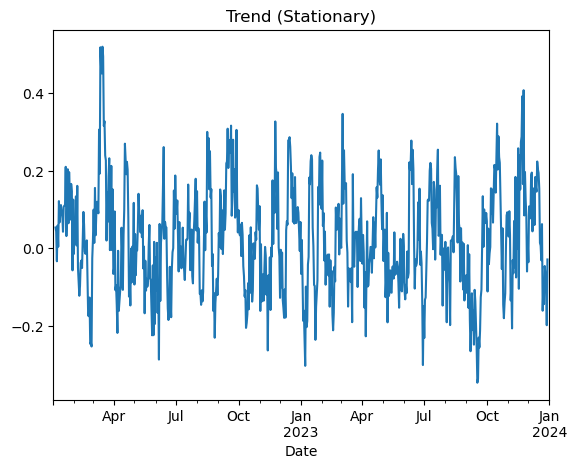

In [24]:
## Plot seasonality from the non-stationary data
plt.title('Trend (Stationary)')
decomp_diff.trend.plot()

## Residual Component

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Next, we'll take a look at the residual component of the data.  The residual component, or noise, represents random variations in the data unrelated to the seasonal or trend components (Mahler, 2023).  In both the original and stationary data, we can see that there are random fluctuations with no clear trends in the residuals.

<Axes: title={'center': 'Residuals'}, xlabel='Date'>

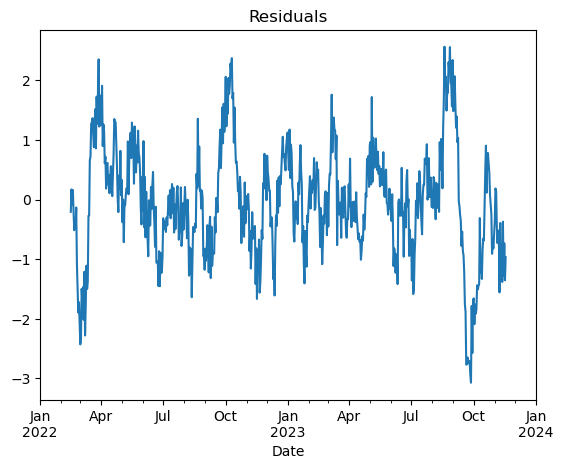

In [25]:
## Plot residuals of non-stationary data
plt.title('Residuals')
decomp.resid.plot()

<Axes: title={'center': 'Residuals'}, xlabel='Date'>

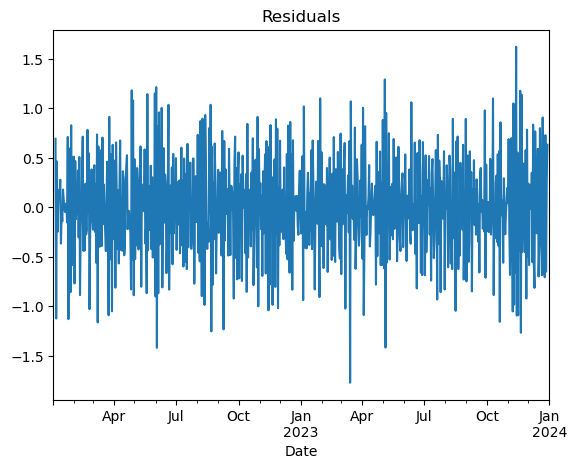

In [26]:
## Plot residuals of stationary data
plt.title('Residuals')
decomp_diff.resid.plot()

## Autocorrelation and Partial Autocorrelation Function

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The first two graphs below represent the autocorrelation and partial autocorrelation functions of the original data.  As we can see, there is an autocorrelation of 1 at lag 0, but values slowly taper with consecutive lags.  Additionally, the partial autocorrelation graph shows that there is significant partial autocorrelation at lags 1 and 2. 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;By analyzing the ACF and PACF graphs for the stationary data, we will be able to identify the best p and q values for our time series model.  As we can see from the stationary ACF graph, lags 1 and 2 have statistically significant autocorrelation.  We know this because these values fall outside of the confidence interval denoted by the blue shaded area on the graph (Monigatti, 2022).  This suggests that the q value of the model should be 1 or 2.  

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The fourth graph below represents the partial autocorrelation function of the stationary data.  We can see a spike at lag 1 followed by a cut off with consecutive lags.  This suggests that the p value of the model should be 1 (Monigatti, 2022).

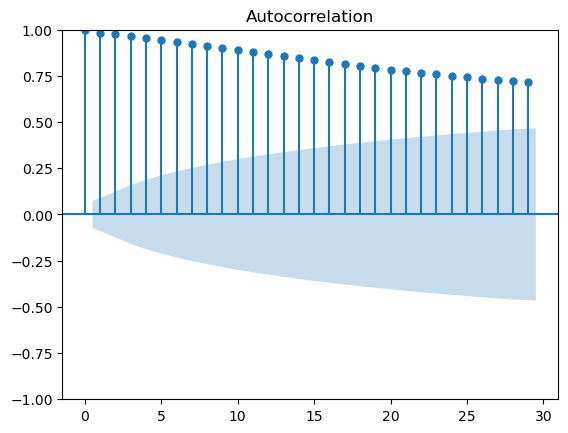

In [27]:
plot_acf(df_telecom['Revenue']);

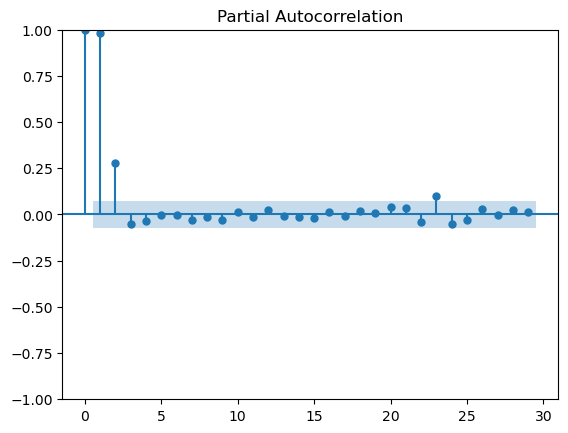

In [28]:
plot_pacf(df_telecom['Revenue']);

Text(0.5, 1.0, 'Autocorrelation (Stationary)')

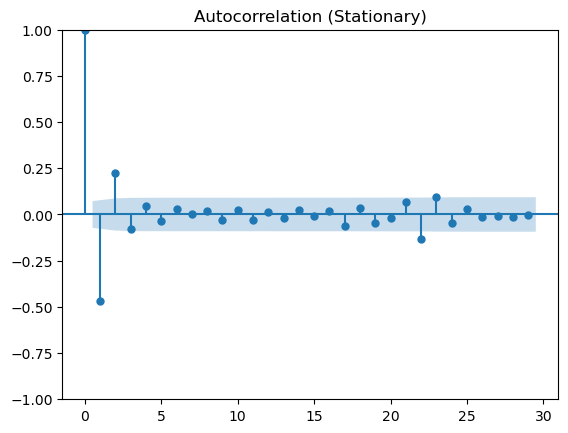

In [29]:
plot_acf(df_diff['Revenue']);
plt.title("Autocorrelation (Stationary)")

Text(0.5, 1.0, 'Partial Autocorrelation (Stationary)')

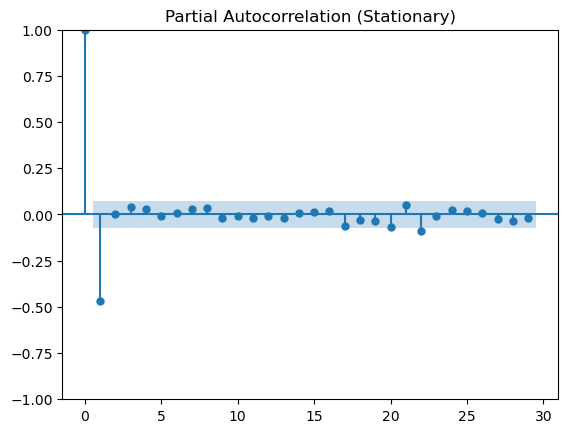

In [30]:
plot_pacf(df_diff['Revenue']);
plt.title("Partial Autocorrelation (Stationary)")

### Spectral Density

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Below are two spectral density graphs.  Spectral density is a frequency domain representation of a time series that is related to the autocovariance time domain (Penn State Eberly College of Science).  The graps below display frequency on the x-axis and spectral density on the y-axis.  With the original data, we can see that spectral density begins at a relatively high magnitude but tapers off over time.  In comparison, the spectral density of the stationary data appears to be consistent as values hover around 0 at each frequency.

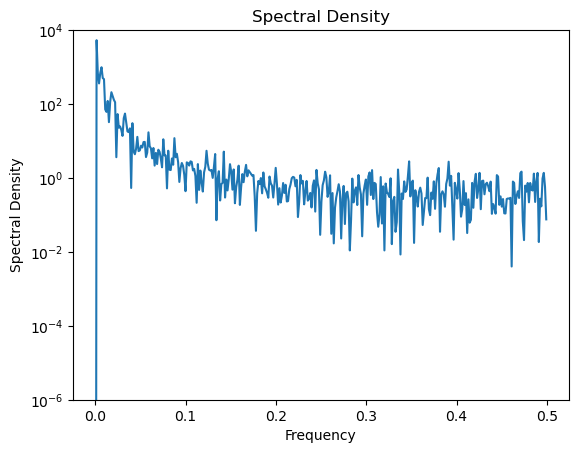

In [31]:
#Plot spectral density using non-stationary data
f, Pxx_den = signal.periodogram(df_telecom["Revenue"])
plt.semilogy(f, Pxx_den)
plt.ylim([1e-6, 1e4])
plt.title("Spectral Density")
plt.xlabel("Frequency")
plt.ylabel("Spectral Density")
plt.show()

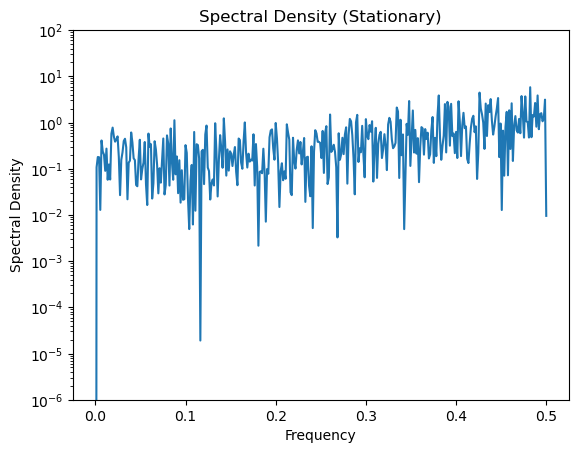

In [32]:
#Plot spectral density using stationary data
f, Pxx_den = signal.periodogram(df_diff["Revenue"])
plt.semilogy(f, Pxx_den)
plt.ylim([1e-6, 1e2])
plt.title("Spectral Density (Stationary)")
plt.xlabel("Frequency")
plt.ylabel("Spectral Density")
plt.show()

## D2.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The next step in my analysis was to identify the best ARIMA model to use with my data.  Based on the  findings from the stationary ACF and PACF graphs, I used the the "auto_arima()" method with the appropriate parameters to determine the optimal order for the model.  The "auto_arima()" method determines best model order by finding the one with lowest AIC score.  In this case, the output indicated that the best model is "SARIMAX(1,1,0)(0,1,0)[90]".  This model produced an AIC score of 1251.010 and a Ljung-Box score of 0.07.  The Ljung-Box score is used to determine whether or not the residuals of the data are independent.  Because the Ljung-Box score is greater than the significance level of 0.05, we know that the residuals of the data are indpendent (Modeltime).  

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Using the best order determined by "auto_arima()", I built a SARIMAX model and fitted it to the training data.  SARIMAX was used rather than ARIMA to account for the seasonality present in the original dataset.  The output of the model was assigned to a variable called "results".  As we can see from the summary, this model produced a Ljung-Box score of 0.08.  This confirms that the residuals of the training data are independent.  

In [33]:
#In-text citation [Task 1 Building Arima Model in Python video]
model = pm.auto_arima(df_telecom, 
                      season = True, m=90,
                      d = 1, D = 1, 
                      start_p = 1, start_q = 1, 
                      max_p = 2, max_q = 2, 
                      max_P = 2, max_Q = 2,
                      trace = True, 
                      error_action = 'ignore', 
                      suppress_warnings = True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[90]             : AIC=inf, Time=67.42 sec
 ARIMA(0,1,0)(0,1,0)[90]             : AIC=1433.753, Time=1.64 sec
 ARIMA(1,1,0)(1,1,0)[90]             : AIC=inf, Time=8.53 sec
 ARIMA(0,1,1)(0,1,1)[90]             : AIC=inf, Time=23.72 sec
 ARIMA(0,1,0)(1,1,0)[90]             : AIC=inf, Time=7.26 sec
 ARIMA(0,1,0)(0,1,1)[90]             : AIC=inf, Time=23.69 sec
 ARIMA(0,1,0)(1,1,1)[90]             : AIC=inf, Time=29.91 sec
 ARIMA(1,1,0)(0,1,0)[90]             : AIC=1251.010, Time=2.41 sec
 ARIMA(1,1,0)(0,1,1)[90]             : AIC=inf, Time=24.96 sec
 ARIMA(1,1,0)(1,1,1)[90]             : AIC=inf, Time=40.12 sec
 ARIMA(2,1,0)(0,1,0)[90]             : AIC=1252.759, Time=1.82 sec
 ARIMA(1,1,1)(0,1,0)[90]             : AIC=1252.813, Time=2.49 sec
 ARIMA(0,1,1)(0,1,0)[90]             : AIC=1290.664, Time=2.39 sec
 ARIMA(2,1,1)(0,1,0)[90]             : AIC=1253.220, Time=9.75 sec
 ARIMA(1,1,0)(0,1,0)[90] intercept   : AIC=1252.987, 

In [33]:
model = SARIMAX(X_train,order=(1,1,0),seasonal_order=(0,1,0,90))
results = model.fit()
results.summary()

/Users/Darian1/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Darian1/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.27355D-01    |proj g|=  6.63939D-04

At iterate    5    f=  8.27355D-01    |proj g|=  9.08273D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5      7      1     0     0   9.083D-07   8.274D-01
  F =  0.82735450681946576     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                            Revenue   No. Observations:                  641
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 90)   Log Likelihood                -530.334
Date:                            Mon, 01 Jul 2024   AIC                           1064.668
Time:                                    17:19:59   BIC                           1073.288
Sample:                                01-01-2022   HQIC                          1068.037
                                     - 10-03-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5163      0.037    -13.810      0.000      -0.590      -0.443
sigma2         0.4025      0.021     18.889      0.000       0.361       0.444
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                 8.13
Prob(Q):                              0.78   Prob(JB):                         0.02
Heteroskedasticity (H):               1.03   Skew:                            -0.01
Prob(H) (two-sided):                  0.84   Kurtosis:                         3.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## D3. 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;With the SARIMAX model now complete, it was time to generate a forecast.  To do this, I used the "get_forecast()" method on the model and specified a length of 90 days.  The output was assigned to an object called "forecast".  This object contains the predicted mean, standard error, and confidence intervals at each forecasted date (Brownlee, 2020).

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;To obtain the predicted revenue, I selected the "predicted_mean" attribute of "forecast" and assigned the output to a variable called "pred_revenue".  I also obtained the confidence intervals using the "conf_int" attribute and assigned the upper and lower bounds to variables called "upper_limits" and "lower_limits".  

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;To see what the forecasted revenue looks like, I printed the values of "pred_revenue".  The output can be seen below.  As we can see, we have successfully predicted revenue for the period between 2023-10-04 and 2024-01-01. A visualization of the forecast and confidence intervals can also be seen below.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The last step I took was to plot the observed revenue (training data), predicted revenue, and confidence intervals together.  In the second graph below, the blue line represents the observed revenue, the red line represents the predicted revenue, and the red shaded area represents the upper and lower confidence intervals.  

In [34]:
#Generate forecast from model
forecast = results.get_forecast(steps=90)
#Select predicted mean of forecast.  This represents predicted_revenue.  
pred_revenue = forecast.predicted_mean
#Get confidence intervals of predictions
confidence_intervals = forecast.conf_int()
#Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower Revenue']
upper_limits = confidence_intervals.loc[:,'upper Revenue']

In [44]:
#Print forecasted revenue values
pred_revenue

2023-10-04    10.985897
2023-10-05    11.145154
2023-10-06    11.830145
2023-10-07    11.653033
2023-10-08    12.052392
                ...    
2023-12-28     9.530457
2023-12-29    10.124172
2023-12-30     9.834989
2023-12-31     9.757177
2024-01-01     9.836904
Freq: D, Name: predicted_mean, Length: 90, dtype: float64

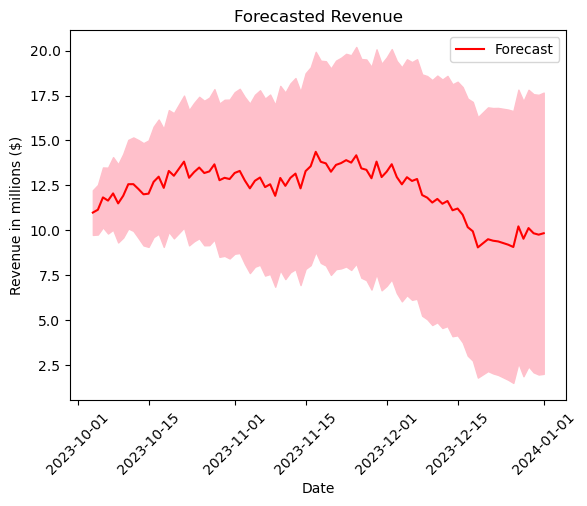

In [45]:
#Plot forecasted revenue values
plt.plot(pred_revenue.index, pred_revenue, color='r', label='Forecast')
#Shade the area between the confidence limits
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink')
# set labels, legends and show plot
plt.title('Forecasted Revenue')
plt.xlabel('Date')
plt.ylabel('Revenue in millions ($)')
plt.xticks(rotation = 45)
plt.legend()
plt.show()

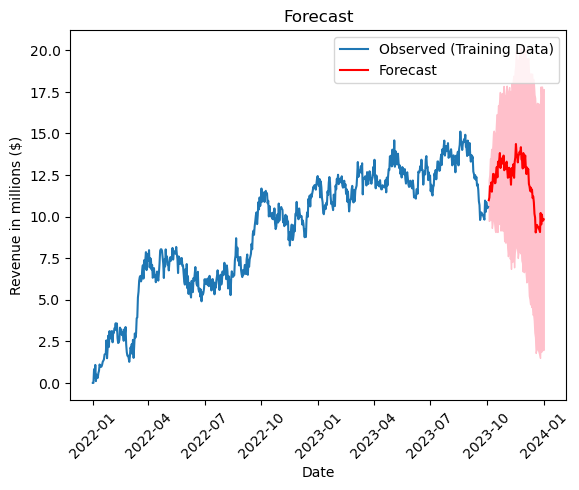

In [37]:
#Plot observed values from training data
plt.plot(X_train.index, X_train, label='Observed (Training Data)')
#Plot the predicted revenue
plt.plot(pred_revenue.index, pred_revenue, color='r', label='Forecast')
#Shade the area between the confidence limits
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink')
# set labels, legends and show plot
plt.title('Forecast')
plt.xlabel('Date')
plt.ylabel('Revenue in millions ($)')
plt.xticks(rotation = 45)
plt.legend()
plt.show()

## D4.

The calculations and output of the analysis have been provided in a jupyter notebook file named "D213_PA_Task1.ipynb"

## D5.

The code used to support the model has been provided in a jupyter notebook file named "D213_PA_Task1.ipynb".

## E1.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;As mentioned previously, I used the ACF and PACF graphs to determine the parameters for the "auto_arima()" function.  This function uses a AIC as a model evaluation metric to determine the best order.  The output of function indicated that the model with the lowest AIC score was "SARIMAX(1, 1, 0)x(0, 1, 0, 90)".  

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The forecast uses a daily prediction interval, which matches the interval of the original data.  I chose a forecast length of 90 days because I thought it would be useful for the telecommunications company to predict revenue for the next fiscal quarter. 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;To evaluate my model, I obtained the mean absolute error.  The output of the code below indicates that the MAE of the model was about 0.4934.  Given that the company's revenue ranges between 0 and 15 million dollars, we can consider this model to be somewhat reliable.  

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;I also evaluted the model using four diagnostic plots.  On the top left graph, we can see that the residuals have a mean of 0 and a uniform variance with relatively few spikes.  To the top right, the histogram resembles a normal distributiobn.  On the bottom left, the Normal Q-Q plot shows a straight line.  Lastly, the ACF plot on the bottom right shows that none of the lags greater than 0 have statistically significant autocorrelation.  Based on each of these visualizations, we can conclude that the model is a good fit (Artley, 2022).

In [38]:
mae = np.mean(np.abs(results.resid))
print("Mean absolute error", mae)

Mean absolute error 0.493426610604369


/var/folders/hm/vp1cd6hn0l3gbzv1b6x3x7_80000gp/T/ipykernel_34500/3366310175.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  results.plot_diagnostics().show()


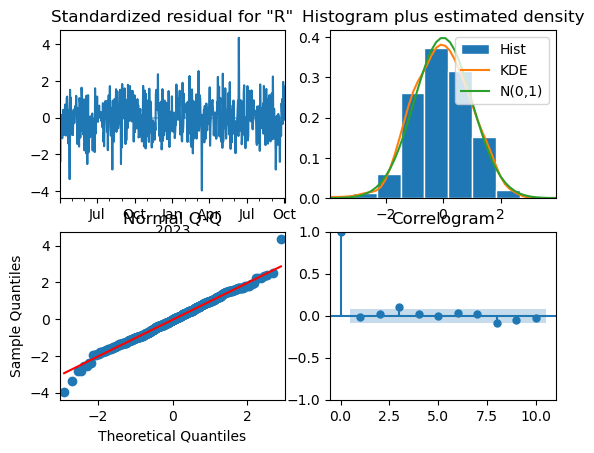

In [39]:
# Create the 4 diagnostic plots
results.plot_diagnostics().show()

## E2.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Below is a graph comparing the forecast of the model to the testing set.  The test set is represented by the blue line, while the forecast is represented by the red line.  As we can see, there appears to be some similarity between the two during the first half of the forecasting period.  After that, the observed values and forecast begin to diverge significantly. 

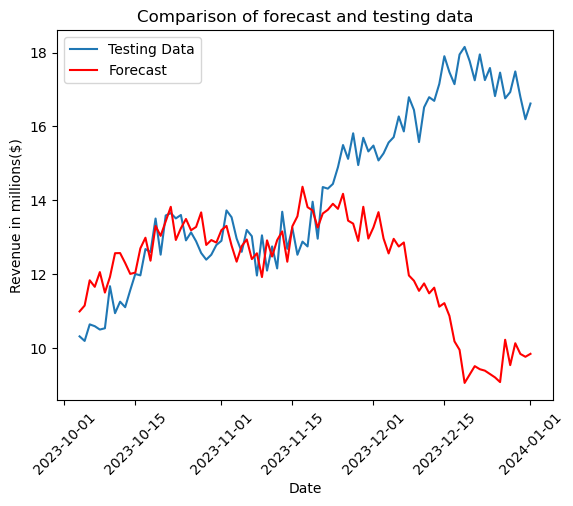

In [40]:
#Plot observed values from Testing Data
plt.plot(X_test.index, X_test, label='Testing Data')
#Plot the predicted revenue
plt.plot(pred_revenue.index, pred_revenue, color='r', label='Forecast')
# set labels, legends and show plot
plt.title('Comparison of forecast and testing data')
plt.xlabel('Date')
plt.ylabel('Revenue in millions($)')
plt.xticks(rotation = 45)
plt.legend()
plt.show()

## E3.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Based on the mean standard error and diagnostic plots discussed previously, we can consider our time series model to be relatively accurate.  It would be a good idea for the telecommunications company to use the model to forecast future revenue.  By doing so, the company can budget ahead for different factors such as marketing, hiring, and inventory.  Additionally, it could use a forecast to set targets for future earnings.  A revenue benchmark for the entire company could help promote organizational alignment.  

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;It would also be in the best interest of the company to continue collecting data and iterating on the model.  By collecting more data, we can train the model even more extensively and generate more accurate forecasts.  As we saw in the previous section, the forecast appeared to diverge from the observed values after roughly 45 days.  By providing more historical data, the model might produce reliable results over longer periods of time.

## F.

A Jupyter Notebook file named "D213_PA_Task1.ipynb" has been submitted alongside this document.

## G.

Kumar G, V. (2024, May 5). Statistical Tests to Check Stationarity in Time Series. Analytics Vidhya. https://www.analyticsvidhya.com/blog/2021/06/statistical-tests-to-check-stationarity-in-time-series-part-1/

Elleh, F. (Narrator). Task 1 Building Arima Model in Python vi [Online video]. https://wgu.hosted.panopto.com/Panopto/Pages/Viewer.aspx?id=1aaf2389-6483-4000-b498-b14f00441d57

## H.

National Institute of Standards and Technology. (n.d.). Stationarity. National Institute of Standards and Technology. https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc442.htm#:~:text=A%20common%20assumption%20in%20many,do%20not%20change%20over%20time.

Kumar G, V. (2024, May 5). Statistical Tests to Check Stationarity in Time Series. Analytics Vidhya. https://www.analyticsvidhya.com/blog/2021/06/statistical-tests-to-check-stationarity-in-time-series-part-1/

Frost, J. (n.d.). Autocorrelation and Partial Autocorrelation in Time Series Data. Statistics by Jim. https://statisticsbyjim.com/time-series/autocorrelation-partial-autocorrelation/

Mahler, C. (2023, August 11). What Is Time Series Decomposition? A Detailed Introduction. InfluxData. https://www.influxdata.com/blog/time-series-decomposition/

Monigatti, L. (2022, August 2). Interpreting ACF and PACF Plots for Time Series Forecasting. Towards Data Science. https://towardsdatascience.com/interpreting-acf-and-pacf-plots-for-time-series-forecasting-af0d6db4061c

PennState Eberly College of Science. (n.d.). 12.1 Estimating the Spectral Density. The Pennsylvania State University. https://online.stat.psu.edu/stat510/lesson/12/12.1

Brownlee, J. (2020, December 10). Understand Time Series Forecast Uncertainty Using Prediction Intervals with Python. Machine Learning Mastery. https://machinelearningmastery.com/time-series-forecast-uncertainty-using-confidence-intervals-python/

MODELTIME. (n.d.). Apply Statistical Tests to Residuals. MODELTIME. https://business-science.github.io/modeltime/reference/modeltime_residuals_test.html#:~:text=The%20Ljung%2DBox%20and%20Box,the%20data%20are%20are%20independent.

Artley, B. (2022, April 26). Time Series Forecasting with ARIMA , SARIMA and SARIMAX. Towards Data Science. https://towardsdatascience.com/time-series-forecasting-with-arima-sarima-and-sarimax-ee61099e78f6